### Курс Профессия Data Science
Итоговый проект. Бриф “Агентство
недвижимости”

Дана задача:
    разработать сервис для предсказания стоимости
домов на основе истории предложений

In [2]:
#pip install swifter

In [4]:
import numpy as np 
import pandas as pd 
import sys
import re
import json
import swifter
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold
#from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool
import ipywidgets
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
#import pylab

#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import KMeans
#from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [5]:
# зафиксируем RANDOM_SEED
RANDOM_SEED = 42
VAL_SIZE   = 0.20   # 20%

In [6]:
def extract_first_digit(x, return_type='float'):
    """ выдать числа идущие в начале строки"""
    if pd.isna(x):
        return None
    else:
        match = re.search(r'^\d(.|,)?\d*', x)
        if match:
            try:
                if return_type=='integer':
                    return int(match.group().replace(',', '.').split('/')[0].strip())
                else: return float(match.group().replace(',', '.').split('/')[0].strip())
            except: return np.nan
        else:
            return None

In [7]:
def extract_cost(x):
    """выдать числа из строки"""
    if pd.isna(x):
        return None
    else:
        match = re.search(r'(?:\d+,*)+', x)
        if match:
            try:
                return float(match.group().replace(',', ''))
            except: return np.nan
                     
        else:
            return None

In [8]:
# Функция для оценки MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Data

In [9]:
df = pd.read_csv(r"C:\Users\Krymg\Final\Недвижимость\data.csv")

In [10]:
df.shape

(377185, 18)

In [11]:
pd.concat([df.agg(['nunique', lambda s: s.unique()[:15]]).transpose(),\
                      pd.Series(df.isnull().sum(), name='null'),
                      pd.Series(df.dtypes, name='dtype')], axis=1)

,nunique,<lambda>,null,dtype
status,159,"[Active, for sale, nan, New construction, New,...",39918,object
private pool,1,"[nan, Yes]",373004,object
propertyType,1280,"[Single Family Home, single-family home, lot/l...",34733,object
street,337076,"[240 Heather Ln, 12911 E Heroy Ave, 2005 Westr...",2,object
baths,229,"[3.5, 3 Baths, 2 Baths, 8 Baths, nan, 2, 3, Ba...",106338,object
homeFacts,321009,"[{'atAGlanceFacts': [{'factValue': '2019', 'fa...",0,object
fireplace,1653,"[Gas Logs, nan, yes, Yes, 2, 0, 1, Not Applica...",274070,object
city,2026,"[Southern Pines, Spokane Valley, Los Angeles, ...",34,object
schools,297365,"[[{'rating': ['4', '4', '7', 'NR', '4', '7', '...",0,object
sqft,25405,"[2900, 1,947 sqft, 3,000 sqft, 6,457 sqft, nan...",40577,object


## Предобработка и очистка данных

Ниже мы обрежем длинные правые хвосты во многих полях, удаляя редкие варианты или выбросы

### status

In [12]:
len(df['status'].unique())

160

Название поля говорит само за себя и имеет множество значений. Скормим их чат боту GPT и попросим классифицировать, выдав  ответ в виде списка питон

Его ответ:
Это общая классификация статусов, которые вы предоставили. 
Однако, стоит отметить, что точное значение каждого статуса может зависеть от местных правил и условий рынка недвижимости.
Это списки Python, которые содержат статусы недвижимости, разделенные на группы.

In [13]:
active = ["Active Backup", "Active Contingent", "Temporary Active", "Active - Contingent", "Active with Contract", "Active", "for sale", "New construction", "New", "For sale", "A Active", "Active/Contingent", "Active Under Contract", "Active Option", "Active Option Contract", "Active With Contingencies", "Active Contingency", "Active - Auction", "Active With Offer", "Active Backup"]
pending = ['Pending Fe', 'P Pending Sale', 'Pending Sh', 'Pending Backups Wanted', 'Pending W/Backup Wanted', 'Pending, Continue to Show', "Pending Offer Approval", "Pending In", "Pending W/Insp Finance", "Pending   Continue To Show   Financing", "Pending W/ Cont.", "Pending W/Escape Clause", "Pending - Continue to Show", "Contract", "Pending Sale", "Accepting backups", "Pending Take Backups", "Lease/Purchase", "Pending", "P", "Under Contract", "Under Contract   Showing", "Under Contract Backups", "Option Pending", "Under Contract Show", "Pending   Continue To Show", "Pending Ab", "Contract P", "Pending Continue To Show", "pending", "Pending Inspection",  "C","Pending With Contingencies","Lease/Purchase Pending","Pending Bring Backup","C Continue Show","Pending Taking Backups","Offer Pending Signature","Under Contract - Show","U Under Contract","Pending - Taking Backups"]
contingent = ["Ct", 'Contingent', "Contingent Finance and Inspection", "CT Insp - Inspection Contingency", "Contingency 48 Hr (+/ )", "Contingent   Release", "Conditional Contract", "Contingent - Sale of Home", "Contingent - Financing", "Contingent Finance And Inspection","Contingent Show","Contingent Take Backup","Contingent   Show","Contingent Lien Holder Release","Contingency Contract","Contingent Escape"]
auction = ["Pre-foreclosure / auction"," / auction","Pre-foreclosure","foreclosure","Foreclosed","Auction","Auction - Active","Active - Auction"]
off_market = ["Back on Market"]
recently_sold = ['Sold: $285,000', 'Sold: $15,000', "recently sold"]
coming_soon = ['Coming soon: Oct 30.', 'Coming soon: Dec 23.','Coming soon: Nov 14.', 'Coming soon: Nov 22.', 'Coming soon: Oct 21.', 'Coming soon: Dec 14.', 'Coming soon: Oct 24.', 'Coming soon: Dec 18.', 'Coming soon: Dec 16.', 'Coming soon: Dec 3.', 'Coming soon: Dec 25.', 'Coming soon: Nov 11.', 'Coming soon: Nov 28.', 'Coming soon: Nov 17.', 'Coming soon: Dec 6.', 'Coming soon: Nov 27.', 'Coming soon: Nov 26.', 'Coming soon: Dec 7.', 'Coming soon: Dec 27.', 'Coming soon: Dec 11.', 'Coming soon: Dec 5.', 'Coming soon: Nov 13.', 'Coming soon: Nov 19.', 'Coming soon: Nov 8.', 'Coming soon: Oct 29.', 'Coming soon: Dec 15.','Coming soon: Dec 20.','Coming soon: Dec 13.','Sold: $285,000','Sold: $15,000','Coming soon: Dec 12.','Coming soon: Nov 5.','Coming soon: Nov 12.',"Coming soon: Nov 21.","Coming soon: Dec 4.","Coming soon: Nov 23.","Coming soon: Nov 29.","Coming soon: Dec 2.","Coming soon: Nov 30.","Coming soon: Dec 10.","Coming soon: Dec 24.","Coming soon: Nov 14.","Coming soon: Nov 22.","Coming soon: Oct 21.","Coming soon: Dec 14.","Coming soon: Oct 24."]
for_rent = ['for rent', 'Apartment for rent']
other = [None, "/ auction" ,"/ auction" ,"Price Change" ,"Option Contract" ,"Pi" ,"Due Diligence Period" ,"Contract Contingent On Buyer Sale" ,"Closed" ,"Listing Extended" ,"For Sale" ,"Condo for rent"]

In [14]:
def encoding_status(row):
    """закодируем множество значений, используя  вышестоящие списки"""
    if row in active: return 'active'
    elif row in pending: return 'pending'
    elif row in contingent: return 'contingent'
    elif row in auction: return 'auction'
    elif row in off_market: return 'off_market'
    elif row in recently_sold: return 'recently_sold'
    elif row in coming_soon: return 'coming_soon'
    elif row in other: return 'other'
    elif row in for_rent: return 'for_rent'
    

In [15]:
df['status'] =  df['status'].swifter.apply(encoding_status)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

<Axes: >

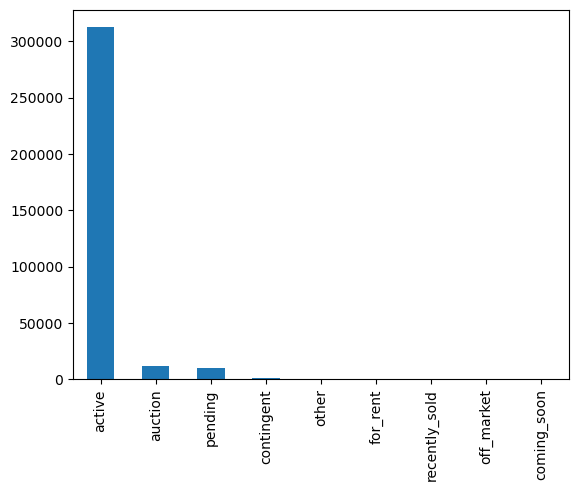

In [16]:
df['status'].value_counts().plot.bar()

In [17]:
sum(df['status'].isna())

40308

In [18]:
# заполним пропуски
df['status'].fillna('active', inplace=True)

### propertyType (тип недвижимости)

In [19]:
# очень много типов
len(df['propertyType'].unique())

1281

In [20]:
lst = df['propertyType'].tolist()

In [21]:
group1 = [x for x in lst if x in ['Single Family Home', 'single-family home', 'Single Family']]
group2 = [x for x in lst if x in ['lot/land',]]
group3 = [x for x in lst if x in ['townhouse',]]
group4 = [x for x in lst if x in ['coop',]]
group5 = [x for x in lst if x in ['multi-family',]]
group6 = [x for x in lst if x in ['Condo',]]
group7 = [x for x in lst if x in ['Penthouse, Split-Level',]]
group8 = [x for x in lst if str(x) == "nan"]


In [22]:
def encoding_propertyType(row):
    """закодируем множество значений, используя  вышестоящие списки"""
    if row in group1: return 'single'
    elif row in group2: return 'land'
    elif row in group3: return 'townhouse'
    elif row in group4: return 'coop'
    elif row in group5: return 'multi'
    elif row in group6: return 'condo'
    elif row in group7: return 'penthouse'
    elif row in group8: return 8
    
  

In [23]:
df['property_type'] =  df['propertyType'].swifter.apply(encoding_propertyType)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

<Axes: >

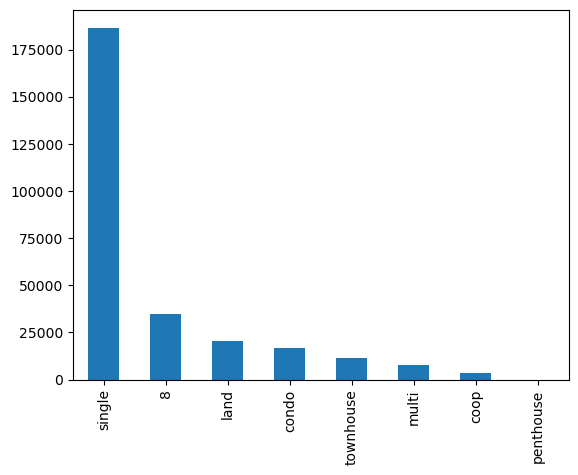

In [24]:
df['property_type'].value_counts().plot.bar()

In [25]:
# заполним пропуски
df.loc[df['property_type'] == 8,'property_type'] = 'single'

In [26]:
# и удалим исходный столбец
del df['propertyType']

### baths ( число ванных комнат)

In [27]:
#Нужно оставить  в поле только число ванных и площадь помещений
df['baths'] = df['baths'].swifter.apply(extract_cost)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

In [28]:
# Все, что более 20, в том числе комнаты и площадь, пусть станет излишеством т.е. будет в группе 20
df['baths'] = df['baths'].swifter.apply(lambda x: 20 if x>=20 else x)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

In [29]:
df['baths'].value_counts()

2.0     114724
3.0      70534
4.0      27609
1.0      18781
20.0     14737
5.0       9747
6.0       4497
0.0       3918
7.0       2143
8.0       1190
9.0        552
10.0       342
11.0       190
12.0       138
13.0        74
16.0        52
14.0        46
18.0        32
15.0        28
17.0        10
19.0         3
Name: baths, dtype: int64

In [30]:
df['baths'].isna().sum()

107838

In [31]:
# заполним пропуски
df['baths'].fillna(2, inplace=True)

<Axes: >

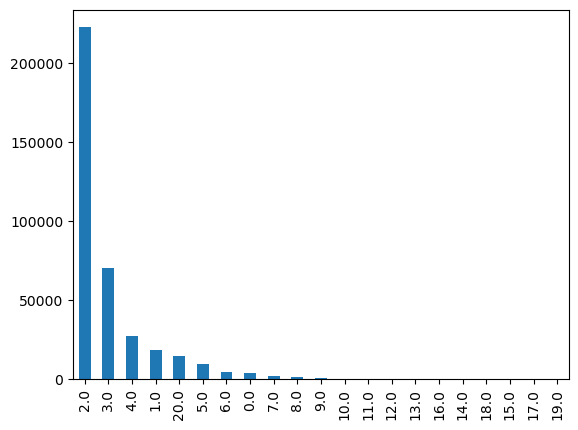

In [32]:
df['baths'].value_counts().plot.bar()

### homeFacts

Это поле содержит факты о жилье: год постройки, год ремонта, отопление, кондиционирование, парковки, стоимость квадратного метра

In [33]:
import ast
def homeFacts_parsing(row):
    return_dict ={}
    try: return_dict['Year_built'] = int(ast.literal_eval(row)['atAGlanceFacts'][0]['factValue'])
    except: return_dict['Year_built'] = np.nan
    try: return_dict['Remodeled_year'] = int(ast.literal_eval(row)['atAGlanceFacts'][1]['factValue'])
    except: return_dict['Remodeled_year'] = np.nan
    try: return_dict['Heating'] = ast.literal_eval(row)['atAGlanceFacts'][2]['factValue']
    except: return_dict['Heating'] = np.nan
    try: return_dict['Cooling'] = ast.literal_eval(row)['atAGlanceFacts'][3]['factValue']
    except: return_dict['Cooling'] = np.nan
    try: return_dict['Parking'] = ast.literal_eval(row)['atAGlanceFacts'][4]['factValue']
    except: return_dict['Parking'] = np.nan
    try: return_dict ['Price/sqft'] = ast.literal_eval(row)['atAGlanceFacts'][6]['factValue']
    except: return_dict['Price/sqft'] = np.nan
    return pd.Series(return_dict)


In [34]:
#Распарсим json
df[['year_built', 'remodeled_year', 'heating', 'cooling', 'parking', 'price/sqft']] = df['homeFacts'].swifter.apply(homeFacts_parsing)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

In [35]:
# и удалим исходный столбец
del df['homeFacts']

#### cooling

<Axes: >

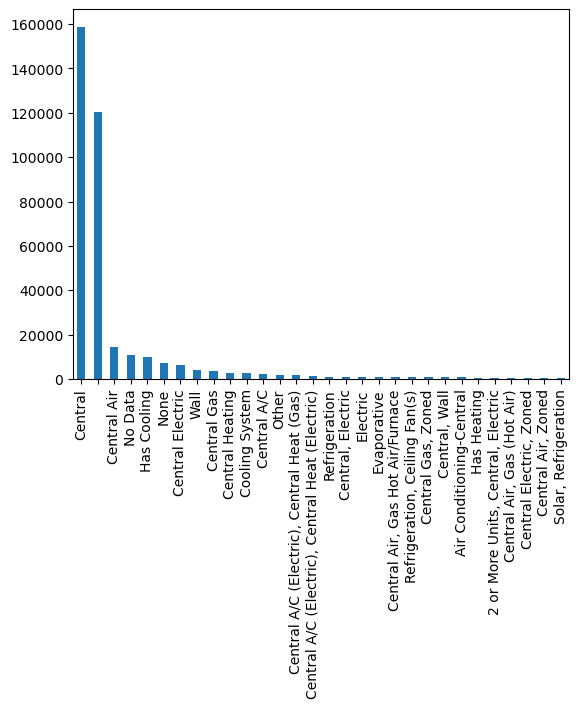

In [36]:
df['cooling'].value_counts()[:30].plot.bar()

Имеем множество значений. Закодируем все разнообразие отопления   как 'есть' или 'нет'

In [37]:
def encoding_cooling(x):
    if 'no data'  in str(x).lower(): return '0'
    elif x=='': return '0'
    else: return '1'  

In [38]:
df['cooling'] =  df['cooling'].swifter.apply(encoding_cooling)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

<Axes: >

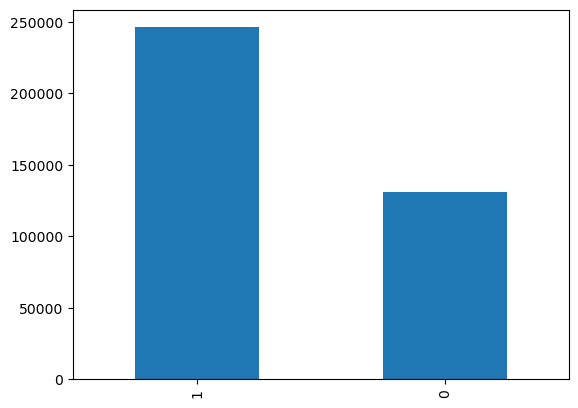

In [39]:
df['cooling'].value_counts().plot.bar()

In [40]:
sum(df['cooling'].isna())

0

#### heating

<Axes: >

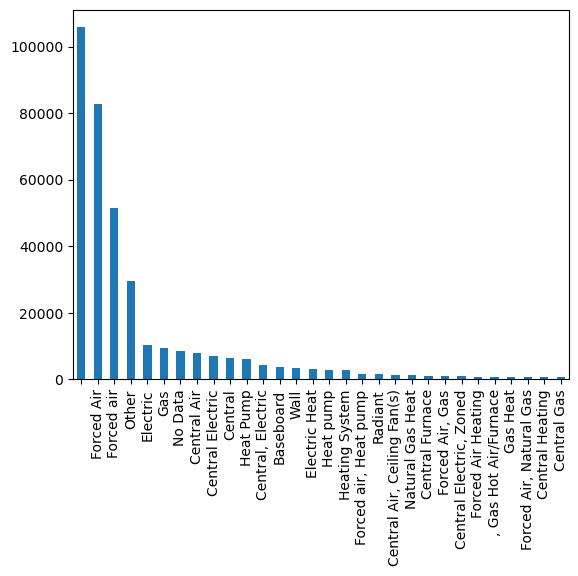

In [41]:
df['heating'].value_counts()[:30].plot.bar()

In [42]:
def encoding_heating(x):
    if 'no data'  in str(x).lower(): return 'no_data'
    elif 'gas' in str(x).lower(): return 'gas'
    elif 'electric'in str(x).lower(): return 'electric'
    elif 'pump' in str(x).lower(): return 'pump'
    elif 'air' in str(x).lower(): return 'air'
    elif x=='': return 6  
    

In [43]:
df['heating'] =  df['heating'].swifter.apply(encoding_heating)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

In [44]:
# заполним пропуски
df.loc[df['heating'] == 6,'heating'] = 'no_data'

<Axes: >

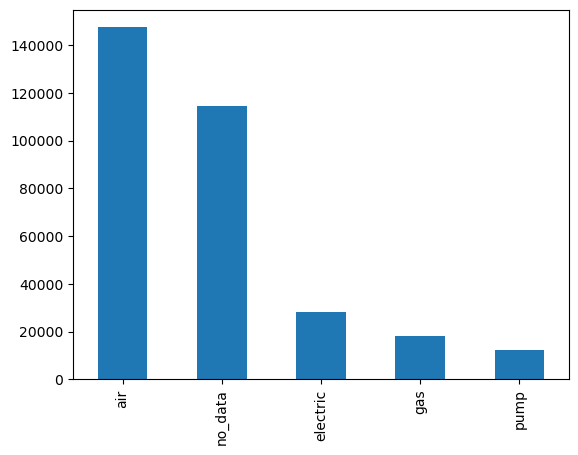

In [45]:
df['heating'].value_counts().plot.bar()

#### parking

<Axes: >

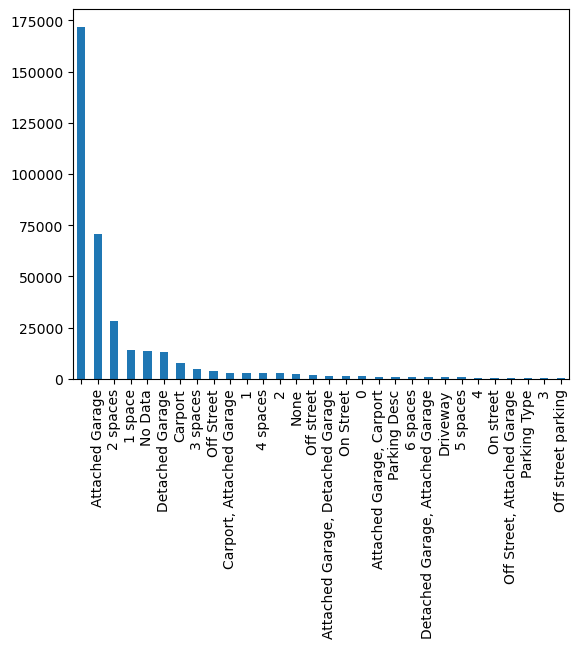

In [46]:
df['parking'].value_counts()[:30].plot.bar()

df.loc[df['cooling'].notna(),'cooling'] = 1
df.loc[df['cooling'].isnull(),'cooling'] = 0

In [47]:
def encoding_parking(x):
    if '4'  in str(x).lower(): return 'four'
    elif '3' in str(x).lower(): return 'three'
    elif '2'in str(x).lower(): return 'two'
    elif '1' in str(x).lower(): return 'one'
    elif 'Carport' in str(x).lower(): return 'carport'
    elif 'none' in str(x).lower(): return 'none'
    elif 'off' in str(x).lower(): return 'off_street'
    elif 'on' in str(x).lower(): return 'on_street'
    elif 'detached' in str(x).lower(): return 'detached'
    elif 'No Data' in str(x).lower(): return 'no_data'
    elif 'attached' in str(x).lower(): return 'attached'
    
    elif x=='': return 'none'  

In [48]:
df['parking'].iloc[103]

''

In [49]:
encoding_parking(df['parking'].iloc[103])

'none'

In [50]:
df['Parking'] =  df['parking'].swifter.apply(encoding_parking)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

<Axes: >

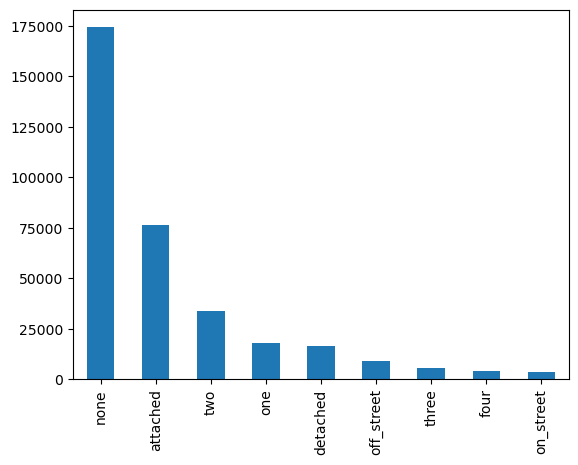

In [51]:
df['Parking'].value_counts().plot.bar()

In [52]:
# и удалим исходный столбец
del df['parking']

### schools

Это JSON данные о школах. Они содержат информацию о рейтинге школы, расстоянии до школы и классах, которые обучаются в школе. Например, в данных указано, что Southern Pines Elementary School имеет рейтинг 4 и находится на расстоянии 2.7 миль. В этой школе обучаются ученики с 3 по 5 классы.

In [53]:
df['schools'][1]

"[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]"

рассчитаем количество школ вокруг объекта, среднее расстояние до них и средний рейтинг ['scools_quantity', 'scools_distance', 'scool_rating']

In [54]:
def scools_data(row):
    return_dict ={}
    scools_quantity = len(ast.literal_eval(row)[0]['name'])
    
    s=0
    for i in ast.literal_eval(row)[0]['data']['Distance']:
        s+=float(extract_first_digit(i))
    
    
    s2=0
    for i in ast.literal_eval(row)[0]['rating']:
        k=extract_first_digit(i) 
        if k: s2+=int(k)
            
    if scools_quantity:
        scools_distance = round(s/scools_quantity, 2)        
        scool_rating = round(s2/scools_quantity, 2)
    else:
        scools_distance = np.nan
        scool_rating= np.nan
    return pd.Series([scools_quantity, scools_distance, scool_rating])

In [55]:
df[['scools_quantity', 'scools_distance', 'scool_rating']] = df['schools'].swifter.apply(scools_data)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

In [56]:
del df['schools']

In [57]:
sum(df['scools_quantity'].isna()),  sum(df['scools_distance'].isna()), sum(df['scool_rating'].isna())

(0, 4284, 4284)

In [58]:
df['scools_distance'].value_counts().iloc[:1]

0.9    3256
Name: scools_distance, dtype: int64

In [59]:
df['scools_distance'].fillna(0.9, inplace=True)

In [60]:
df['scool_rating'].value_counts().iloc[:1]

6.0    20590
Name: scool_rating, dtype: int64

In [61]:
df['scool_rating'].fillna(6, inplace=True)

<Axes: >

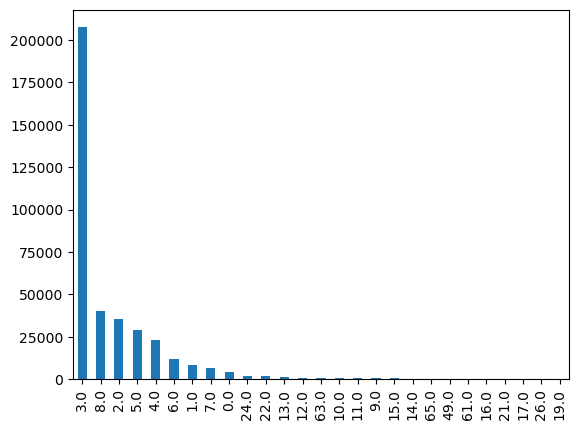

In [62]:
df['scools_quantity'].value_counts().plot.bar()

<Axes: >

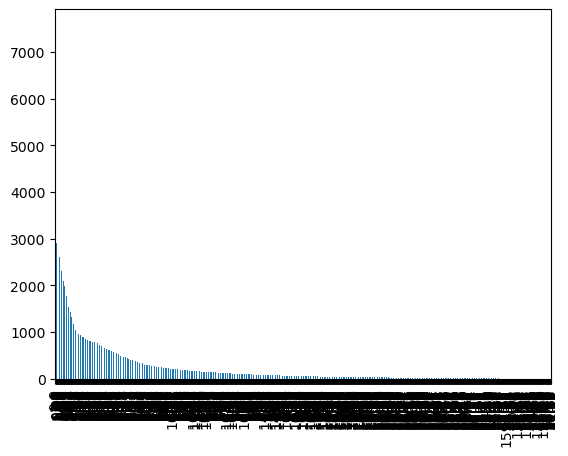

In [63]:
df['scools_distance'].value_counts().plot.bar()

In [64]:
df['scools_distance'] = df['scools_distance'].swifter.apply(lambda x: x if x<20 else 20)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

<Axes: xlabel='scools_distance'>

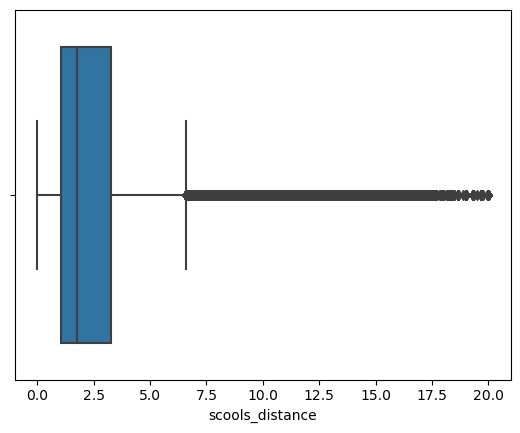

In [65]:
sns.boxplot(x=df["scools_distance"])

<Axes: >

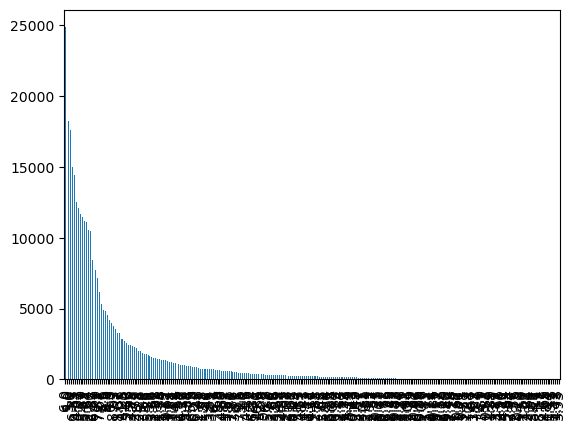

In [66]:
df['scool_rating'].value_counts().plot.bar()

<Axes: xlabel='scool_rating'>

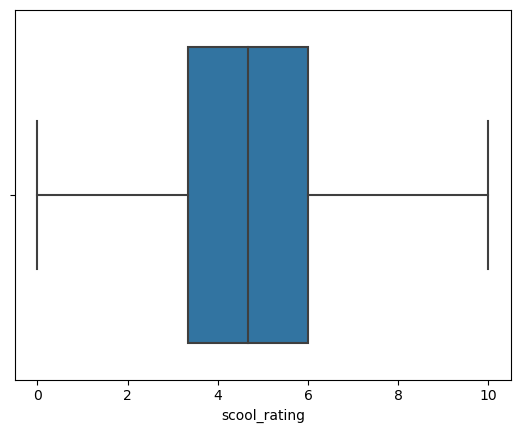

In [67]:
sns.boxplot(x=df["scool_rating"])

### sqft

In [68]:
#Это площадь, преобразем ее в числовой формат
df['sqft'] = df['sqft'].swifter.apply(extract_first_digit)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

In [69]:
sum(df['sqft'].isna())

65075

In [70]:
df['sqft'].value_counts().iloc[:10]

0.0      11854
1.2       1196
1.0        946
1.5        846
1.1        818
1.8        795
1.4        737
2.0        723
800.0      711
1.6        674
Name: sqft, dtype: int64

In [71]:
sum(df['sqft'].isna())

65075

In [72]:
df['sqft'].fillna(1.2, inplace=True)

### beds

In [73]:
#Это число спален, преобразуем в числовой вид
df['beds'] = df['beds'].swifter.apply(extract_first_digit, return_type='integer')

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

In [74]:
sum(df['beds'].isna())

129727

In [75]:
df['beds'].value_counts().iloc[:5]

3.0    97749
4.0    63717
2.0    47727
5.0    20337
6.0     6276
Name: beds, dtype: int64

In [76]:
df['beds'].fillna(3, inplace=True)

### Price/sqft

In [77]:
# Стоимость за квадратный метр, преобразуем в число
df['price/sqft'] = df['price/sqft'].swifter.apply(extract_cost)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

### target

In [78]:
#Целевой показатель - стомость, преобразуем в число
df['target'] = df['target'].swifter.apply(extract_cost)

Pandas Apply:   0%|          | 0/377185 [00:00<?, ?it/s]

In [79]:
df = df.dropna(subset=['target'])

In [80]:
df['target'] = df['target'].swifter.apply(lambda x: x if x<10000000 else 100000000)

Pandas Apply:   0%|          | 0/374704 [00:00<?, ?it/s]

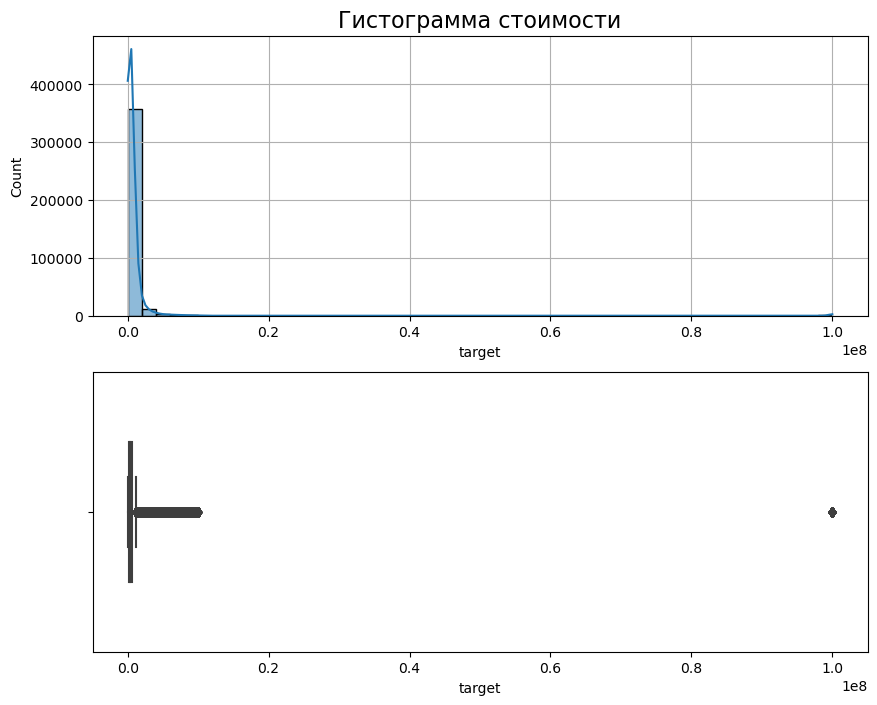

<Figure size 1000x700 with 0 Axes>

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
fig = plt.figure(figsize=(10, 7))
histplot = sns.histplot(
    data=df,
    x='target',
    bins=50,
    kde=True,
    ax=axes[0]
);
boxplot = sns.boxplot(
    data=df,
    x='target',
    orient='h',
    width=0.5,
    ax=axes[1]
);
histplot.set_title('Стоимость');
axes[0].set_title('Гистограмма стоимости', fontsize=16)

histplot.grid()

#### Имеем распределение с длинным хвостом, в дальнейшем нужно проверить влияние  логарифмирования

### MlsId

Служба множественного листинга (MLS) — это база данных, созданная сотрудничающими брокерами по недвижимости для предоставления данных о недвижимости для продажи. 
MLS позволяет брокерам просматривать списки недвижимости для продажи друг у друга с целью связать покупателей с продавцами.
Служба множественного листинга помогает агентам по недвижимости и брокерам связываться, объединяя и обмениваясь информацией при распределении комиссионных. Вероятно наличие в данной базе повышает скорость продажи и следовательно стоимость.

Закодируем все разнообразие отопления как 'есть' или 'нет'

In [82]:
def mls_sum(row):
    val = np.nan
    if row['mls-id'].isna(): val = 0 
    else: val = 1
    if row['MlsId'].isna(): val = 0 
    else: val = 1
    return val
    

In [83]:
df.loc[df['mls-id'].notna(),'mls-id'] = 1
df.loc[df['mls-id'].isnull(),'mls-id'] = 0


In [84]:
df.loc[df['MlsId'].notna(),'MlsId'] = 1
df.loc[df['MlsId'].isnull(),'MlsId'] = 0

In [85]:
df['mlsid'] = df['mls-id'] + df['MlsId']
df.loc[df['mlsid'] == 2,'MlsId'] = 1

In [86]:
del df['mls-id']
del df['MlsId']

<Axes: >

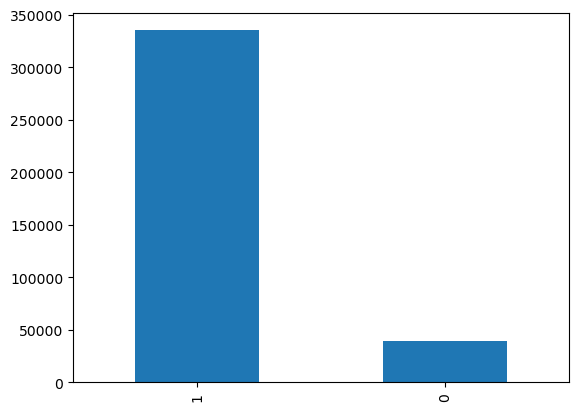

In [87]:
df['mlsid'].value_counts().plot.bar()

In [88]:
sum(df['mlsid'].isna())

0

### private pool (бассейн)

Закодируем все разнообразие отопления как 'есть' или 'нет'

In [89]:
df.loc[df['private pool'].notna(),'private pool'] = 1
df.loc[df['private pool'].isnull(),'private pool'] = 0

In [90]:
df.loc[df['PrivatePool'].notna(),'PrivatePool'] = 1
df.loc[df['PrivatePool'].isnull(),'PrivatePool'] = 0

In [91]:
df['private_pool'] = df['private pool'] + df['PrivatePool']
df.loc[df['private_pool'] == 2,'private_pool'] = 1

In [92]:
del df['private pool']
del df['PrivatePool']

<Axes: >

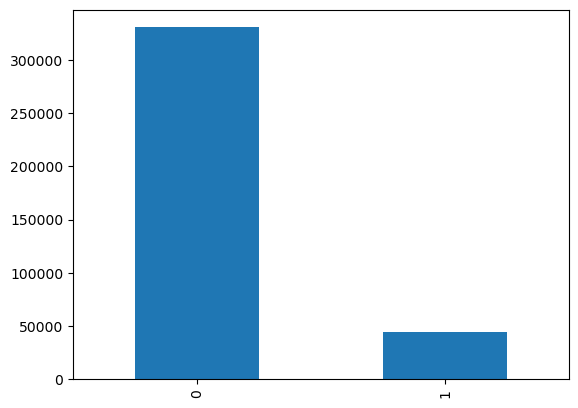

In [93]:
df['private_pool'].value_counts().plot.bar()

In [94]:
sum(df['private_pool'].isna())

0

### stories

<Axes: >

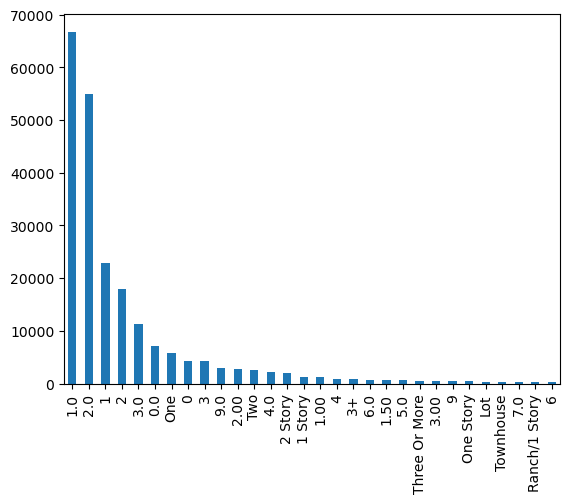

In [95]:
df['stories'].value_counts()[:30].plot.bar()

In [96]:
df['stories'].value_counts()[:10]

1.0    66808
2.0    55003
1      22795
2      17976
3.0    11233
0.0     7209
One     5758
0       4231
3       4201
9.0     2914
Name: stories, dtype: int64

In [97]:
one = ['1.0', '1','One', '1 Story', '1.00', 'One Story', 'Ranch/1 Story']
two = ['2.0', '2', '2.00', 'Two', '2 Story']

In [98]:
def encoding_stories(row):
    """закодируем множество значений, используя  вышестоящие списки"""
    if row in (one): return 1
    elif row in (two): return 2
    else: return 3    

In [99]:
df['stories'] =  df['stories'].swifter.apply(encoding_stories)

Pandas Apply:   0%|          | 0/374704 [00:00<?, ?it/s]

In [100]:
sum(df['stories'].isna())

0

### fireplace

Закодируем все разнообразие отопления как 'есть' или 'нет'

In [101]:
df.loc[df['fireplace'].notna(),'fireplace'] = 1
df.loc[df['fireplace'].isnull(),'fireplace'] = 0

<Axes: >

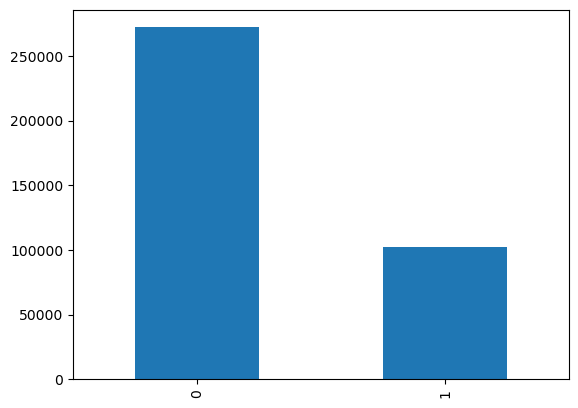

In [102]:
df['fireplace'].value_counts()[:30].plot.bar()

In [103]:
to_delete = [  'remodeled_year']

In [104]:
df.drop (columns=to_delete, axis= 1 , inplace= True )

#### Что мы имеем в итоге очистки данных

In [105]:
pd.concat([df.agg(['nunique', lambda s: s.unique()[:15]]).transpose(),\
                      pd.Series(df.isnull().sum(), name='null'),
                      pd.Series(df.dtypes, name='dtype')], axis=1)

,nunique,<lambda>,null,dtype
status,8,"[active, pending, auction, for_rent, contingen...",0,object
street,334751,"[240 Heather Ln, 12911 E Heroy Ave, 2005 Westr...",2,object
baths,21,"[3.0, 2.0, 8.0, 20.0, 4.0, 5.0, 7.0, 1.0, 6.0,...",0,float64
fireplace,2,"[1, 0]",0,object
city,2019,"[Southern Pines, Spokane Valley, Los Angeles, ...",34,object
sqft,12550,"[2900.0, 1.947, 3.0, 6.457, 1.2, 897.0, 1.507,...",0,float64
zipcode,4541,"[28387, 99216, 90049, 75205, 32908, 19145, 347...",0,object
beds,76,"[4.0, 3.0, 5.0, 2.0, 8.0, 1.0, 6.0, 12.0, 14.0...",0,float64
state,39,"[NC, WA, CA, TX, FL, PA, TN, IA, NY, OR, DC, N...",0,object
stories,3,"[3, 2, 1]",0,int64


In [106]:
#Удалим все строки с пропусками
df.dropna(inplace=True)

In [107]:
#Поделим фичи на числовые и категориальные
num_features = [col for col in df.columns if df[col].dtype in ['float64','int64']]
num_features.remove('target') #не забыв удалить из списка целевую колону
cat_features = [col for col in df.columns if df[col].dtype not in ['float64','int64']]


In [108]:
num_features

['baths',
 'sqft',
 'beds',
 'stories',
 'year_built',
 'price/sqft',
 'scools_quantity',
 'scools_distance',
 'scool_rating']

In [109]:
cat_features

['status',
 'street',
 'fireplace',
 'city',
 'zipcode',
 'state',
 'property_type',
 'heating',
 'cooling',
 'Parking',
 'mlsid',
 'private_pool']

## Machine Learning

### Train Split

In [110]:
y = df['target']
X = df.loc[:, df.columns !='target']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### Baseline

#### CatBoostRegressor

In [112]:
#pip install ipywidgets  
# визуализация не работает ошибки catboost-widget победить не удалось

In [113]:
# !jupyter nbextension enable --py widgetsnbextension

In [114]:
model = CatBoostRegressor(
                          random_seed = RANDOM_SEED,
                          #silent=True,
                         )
model.fit(X_train, y_train,
         cat_features=cat_features,
         #eval_set=(X_test, y_test),
         verbose=False,
        # use_best_model=True,       
         plot=True
         )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [115]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 40.03%


In [116]:
print('Hello')

Hello


###  Прологарифмируем тяжелый хвост целевого признака

In [117]:
df['target_log'] = df['target'].swifter.apply(np.log)

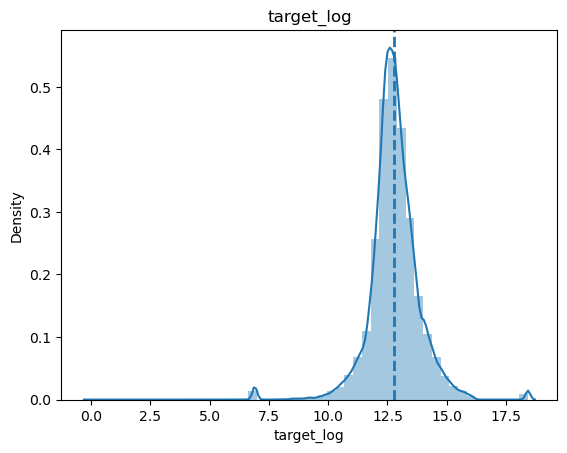

In [118]:
#checking the target variables for distribution
sns.distplot(df['target_log'])
plt.axvline(x=df['target_log'].mean(), linestyle='--', linewidth=2)
plt.title('target_log');

In [119]:
y = df['target_log']
# Удалим целевые показатели
X = df.loc[:, df.columns !='target']
X = X.loc[:, X.columns !='target_log'] 

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [121]:
model = CatBoostRegressor(
                          random_seed = RANDOM_SEED,
                          #silent=True,
                         )
model.fit(X_train, y_train,
         cat_features=cat_features,
         #eval_set=(X_test, y_test),
         verbose=False,
        # use_best_model=True,       
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [122]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 0.39%


#### Логарифмирование кардинально улучшило точность

Может произошла утечка данных? Кажется нет

<Axes: >

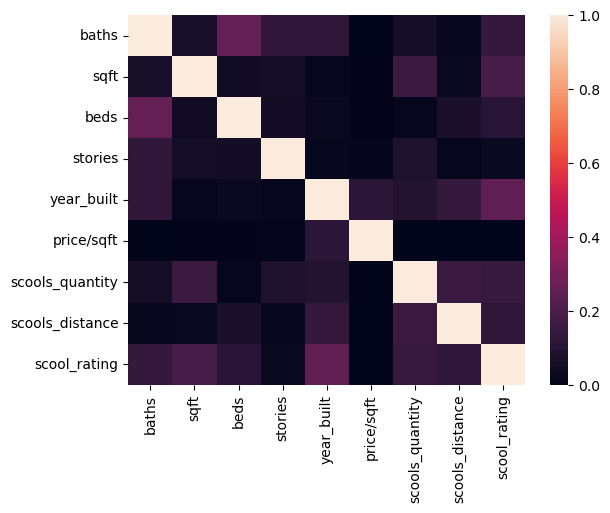

In [123]:
sns.heatmap(df[num_features].corr().abs(), vmin=0, vmax=1)

### Попробуем другие модели только на числовых показателях

In [124]:
XX = df[num_features] #Ограничимся только числовыми показателями, это как показано ниже не ухудшает точность
yy = df['target']

In [125]:
num_features

['baths',
 'sqft',
 'beds',
 'stories',
 'year_built',
 'price/sqft',
 'scools_quantity',
 'scools_distance',
 'scool_rating']

In [126]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [127]:
XX_log = df[num_features]
yy_log = df['target_log']

In [128]:
XX_train_log, XX_test_log, yy_train_log, yy_test_log = train_test_split(XX_log, yy_log, 
                                                test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

#### CatBoostRegressor 

In [129]:
model = CatBoostRegressor(
                          random_seed = RANDOM_SEED,
                          #silent=True,
                         )
model.fit(XX_train_log, yy_train_log,
         #cat_features=cat_features,
         #eval_set=(X_test, y_test),
         verbose=False,
        # use_best_model=True,       
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [130]:
# оцениваем точность
predict = model.predict(XX_test_log)
print(f"Точность модели по метрике MAPE: {(mape(yy_test_log, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 0.37%


#### GradientBoosting

In [131]:
gbr = GradientBoostingRegressor(loss ='ls', max_depth=10, n_estimators = 900)
gbr.fit (XX_train, yy_train)

GradientBoostingRegressor(loss='ls', max_depth=10, n_estimators=900)

In [132]:
pred_gbr = gbr.predict(XX_test)

print(f"Точность модели по метрике MAPE: {(mape(yy_test, pred_gbr))*100:0.2f}%")

Точность модели по метрике MAPE: 25.22%


При логарифмировании целевого признака

In [133]:
gbr = GradientBoostingRegressor(loss ='ls', max_depth=10, n_estimators = 900)
gbr.fit (XX_train_log, yy_train_log)

GradientBoostingRegressor(loss='ls', max_depth=10, n_estimators=900)

In [134]:
pred_gbr = gbr.predict(XX_test_log)

print(f"Точность модели по метрике MAPE: {(mape(yy_test_log, pred_gbr))*100:0.2f}%")

Точность модели по метрике MAPE: 0.28%


#### Random Forest

In [135]:
rf = ExtraTreesRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1,
                         bootstrap=True, verbose=1)
rf.fit(XX_train, yy_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.1s finished


ExtraTreesRegressor(bootstrap=True, n_estimators=300, n_jobs=-1,
                    random_state=42, verbose=1)

In [136]:
pred_rf = rf.predict(XX_test)


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.6s finished


In [137]:

print(f"Точность модели по метрике MAPE: {(mape(yy_test, pred_rf))*100:0.2f}%")
#print(f'Mean Absolute Percentage Error: {MAPE}')

Точность модели по метрике MAPE: 21.83%


При логарифмировании целевого признака

In [138]:
rf = ExtraTreesRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1,
                         bootstrap=True, verbose=1)
rf.fit(XX_train_log, yy_train_log)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.7s finished


ExtraTreesRegressor(bootstrap=True, n_estimators=300, n_jobs=-1,
                    random_state=42, verbose=1)

In [139]:
pred_rf = rf.predict(XX_test_log)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.6s finished


In [140]:
print(f"Точность модели по метрике MAPE: {(mape(yy_test_log, pred_rf))*100:0.2f}%")
#print(f'Mean Absolute Percentage Error: {MAPE}')

Точность модели по метрике MAPE: 0.65%


#### XGBRegressor

In [141]:
xg_reg = xgb.XGBRegressor ( colsample_bytree= 0.7, 
                            learning_rate= 0.03, 
                            max_depth= 12, 
                            min_child_weight = 4, 
                            n_estimators = 500, 
                            nthread = 4, 
                            
                            subsample = 0.7)

#(objective='reg:squarederror', colsample_bytree=0.5,
#                          learning_rate=0.05, max_depth=12, alpha=1,
#                          n_estimators=1000)
xg_reg.fit(XX_train, yy_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=12, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [142]:
predict_xg_reg = xg_reg.predict(XX_test)
print(f"Точность модели по метрике MAPE: {(mape(yy_test, predict_xg_reg))*100:0.2f}%")

Точность модели по метрике MAPE: 41.83%


При логарифмировании целевого признака

In [143]:
xg_reg = xgb.XGBRegressor ( colsample_bytree= 0.7, 
                            learning_rate= 0.03, 
                            max_depth= 12, 
                            min_child_weight = 4, 
                            n_estimators = 500, 
                            nthread = 4, 
                            
                            subsample = 0.7)

#(objective='reg:squarederror', colsample_bytree=0.5,
#                          learning_rate=0.05, max_depth=12, alpha=1,
#                          n_estimators=1000)
xg_reg.fit(XX_train_log, yy_train_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=12, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
predict_xg_reg = xg_reg.predict(XX_test_log)
print(f"Точность модели по метрике MAPE: {(mape(yy_test_log, predict_xg_reg))*100:0.2f}%")

Точность модели по метрике MAPE: 0.33%


### Подбор гиперпараметров

GradientBoosting показывает лучшие результаты

In [145]:
clf = GradientBoostingRegressor(loss ='ls')

In [146]:
parametrs = { 'learning_rate' : [0.001, 0.1],
              'n_estimators': range (900, 5000),
              'max_depth': range (1, 20),
             }

In [147]:
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(XX_train_log, yy_train_log)

KeyboardInterrupt: 

In [ ]:
grid.best_params_

По истечении 8 часов обработка не была закончена. Прервем и будем использовать наилучший вариант  из имеющихся 

In [148]:
gbr = GradientBoostingRegressor(loss ='ls', max_depth=10, n_estimators = 900)
gbr.fit (XX_train_log, yy_train_log)

GradientBoostingRegressor(loss='ls', max_depth=10, n_estimators=900)

In [149]:
pred_gbr = gbr.predict(XX_test_log)

print(f"Точность модели по метрике MAPE: {(mape(yy_test_log, pred_gbr))*100:0.2f}%")

Точность модели по метрике MAPE: 0.29%


In [152]:
import pickle

In [153]:
# Производим сериализацию обученной модели
with open('myfile.pkl', 'wb') as output:
    pickle.dump(gbr, output)